In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-transactions-dataset/Retail_Transactions_Dataset.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Data loading, EDA & Data Preporasion

In [3]:
df = pd.read_csv('/kaggle/input/retail-transactions-dataset/Retail_Transactions_Dataset.csv')

In [4]:
df.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Transaction_ID     1000000 non-null  int64  
 1   Date               1000000 non-null  object 
 2   Customer_Name      1000000 non-null  object 
 3   Product            1000000 non-null  object 
 4   Total_Items        1000000 non-null  int64  
 5   Total_Cost         1000000 non-null  float64
 6   Payment_Method     1000000 non-null  object 
 7   City               1000000 non-null  object 
 8   Store_Type         1000000 non-null  object 
 9   Discount_Applied   1000000 non-null  bool   
 10  Customer_Category  1000000 non-null  object 
 11  Season             1000000 non-null  object 
 12  Promotion          666057 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 92.5+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
for c in ['Transaction_ID', 'Customer_Name', 'Product', 'Date', 'City']:
    print(df[c].nunique())

1000000
329738
571947
996337
10


* **1,000,000 transactions**
* **329,738 customers**
* **571,947 unique products**
* **10 cities**

In [8]:
df.groupby('Customer_Name')['Transaction_ID'].count().describe()

count    329738.000000
mean          3.032711
std           6.383718
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         454.000000
Name: Transaction_ID, dtype: float64

In [9]:
cust_counts = df.groupby('Customer_Name')['Transaction_ID'].count()
outliers = cust_counts[cust_counts == cust_counts.max()]
outliers

Customer_Name
Michael Smith    454
Name: Transaction_ID, dtype: int64

In [10]:
df[df['Customer_Name'].isin(outliers.index)]

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
390,1000000390,2024-03-14 19:01:00,Michael Smith,['Salmon'],8,65.90,Debit Card,New York,Convenience Store,False,Professional,Spring,NaN
3664,1000003664,2022-11-25 02:56:15,Michael Smith,"['Soda', 'Ironing Board']",4,38.64,Credit Card,Los Angeles,Warehouse Club,False,Middle-Aged,Fall,Discount on Selected Items
5671,1000005671,2021-08-24 16:03:47,Michael Smith,"['Salmon', 'Carrots', 'Mayonnaise']",9,10.11,Debit Card,Boston,Pharmacy,True,Middle-Aged,Summer,NaN
6343,1000006343,2023-08-09 11:42:15,Michael Smith,"['Toilet Paper', 'Lawn Mower', 'Pasta', 'Orange']",7,36.80,Mobile Payment,Los Angeles,Convenience Store,True,Homemaker,Spring,Discount on Selected Items
9924,1000009924,2020-03-26 22:53:34,Michael Smith,"['Insect Repellent', 'Pancake Mix']",7,19.22,Credit Card,Houston,Specialty Store,True,Homemaker,Spring,Discount on Selected Items
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995620,1000995620,2021-08-07 18:08:43,Michael Smith,"['Sponges', 'Shaving Cream', 'Beef', 'Apple']",3,42.30,Credit Card,Miami,Convenience Store,False,Homemaker,Winter,BOGO (Buy One Get One)
996466,1000996466,2020-02-14 12:38:38,Michael Smith,"['Mayonnaise', 'Deodorant']",8,47.83,Credit Card,Houston,Convenience Store,False,Senior Citizen,Winter,BOGO (Buy One Get One)
997142,1000997142,2021-07-16 12:52:46,Michael Smith,"['Pasta', 'Hair Gel', 'Broom']",7,8.11,Debit Card,Boston,Specialty Store,True,Student,Spring,Discount on Selected Items
997374,1000997374,2020-03-22 05:34:56,Michael Smith,['Pickles'],7,49.30,Credit Card,Dallas,Pharmacy,True,Young Adult,Spring,NaN


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


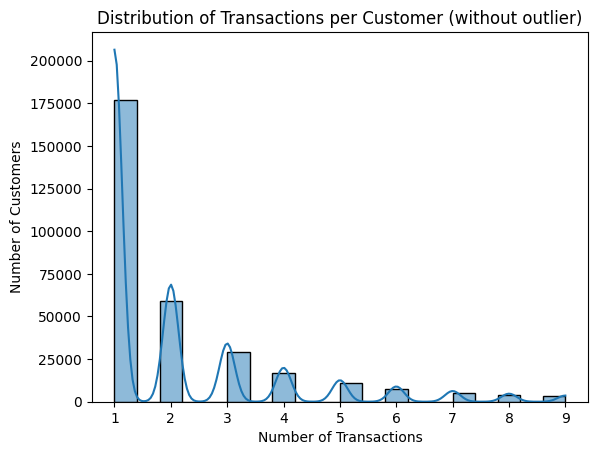

In [11]:
transactions_per_customer = df.groupby('Customer_Name')['Transaction_ID'].count()
transactions_no_outlier = transactions_per_customer[transactions_per_customer < 10]
sns.histplot(transactions_no_outlier, kde=True, bins=20, edgecolor='black')
plt.title('Distribution of Transactions per Customer (without outlier)')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


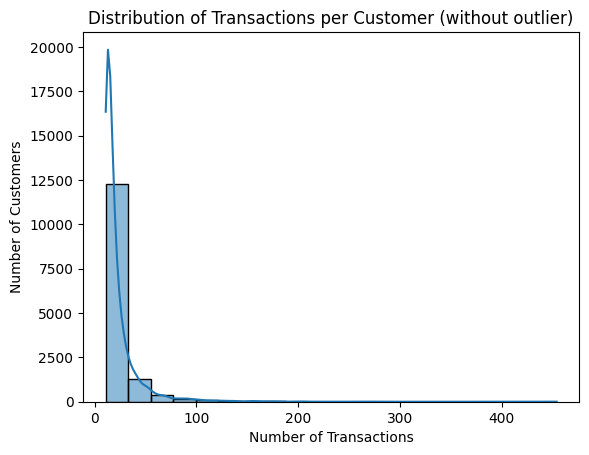

In [12]:
transactions_max = transactions_per_customer[transactions_per_customer > 10]
sns.histplot(transactions_max, kde=True, bins=20, edgecolor='black')
plt.title('Distribution of Transactions per Customer (without outlier)')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [13]:
print(df['Date'].min())
print(df['Date'].max())

2020-01-01 00:03:54
2024-05-18 19:31:03


In [14]:
df['Total_Items'].describe()

count    1000000.000000
mean           5.495941
std            2.871654
min            1.000000
25%            3.000000
50%            5.000000
75%            8.000000
max           10.000000
Name: Total_Items, dtype: float64

In [15]:
sum(df['Total_Items'] == 1)

100097

In [16]:
duplicated = df.Product[df['Product'].duplicated()]

In [17]:
duplicated.info()

<class 'pandas.core.series.Series'>
Index: 428053 entries, 76 to 999997
Series name: Product
Non-Null Count   Dtype 
--------------   ----- 
428053 non-null  object
dtypes: object(1)
memory usage: 6.5+ MB


In [18]:
df.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


In [19]:
import ast
df['Product'] = df['Product'].apply(ast.literal_eval)
type(df.loc[0, 'Product'])

list

In [20]:
from itertools import chain

unique_products = set(chain.from_iterable(df['Product']))
len(unique_products), unique_products

(81,
 {'Air Freshener',
  'Apple',
  'BBQ Sauce',
  'Baby Wipes',
  'Banana',
  'Bath Towels',
  'Beef',
  'Bread',
  'Broom',
  'Butter',
  'Canned Soup',
  'Carrots',
  'Cereal',
  'Cereal Bars',
  'Cheese',
  'Chicken',
  'Chips',
  'Cleaning Rags',
  'Cleaning Spray',
  'Coffee',
  'Deodorant',
  'Diapers',
  'Dish Soap',
  'Dishware',
  'Dustpan',
  'Eggs',
  'Extension Cords',
  'Feminine Hygiene Products',
  'Garden Hose',
  'Hair Gel',
  'Hand Sanitizer',
  'Honey',
  'Ice Cream',
  'Insect Repellent',
  'Iron',
  'Ironing Board',
  'Jam',
  'Ketchup',
  'Laundry Detergent',
  'Lawn Mower',
  'Light Bulbs',
  'Mayonnaise',
  'Milk',
  'Mop',
  'Mustard',
  'Olive Oil',
  'Onions',
  'Orange',
  'Pancake Mix',
  'Paper Towels',
  'Pasta',
  'Peanut Butter',
  'Pickles',
  'Plant Fertilizer',
  'Potatoes',
  'Power Strips',
  'Razors',
  'Rice',
  'Salmon',
  'Shampoo',
  'Shaving Cream',
  'Shower Gel',
  'Shrimp',
  'Soap',
  'Soda',
  'Spinach',
  'Sponges',
  'Syrup',
  'Tea'

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

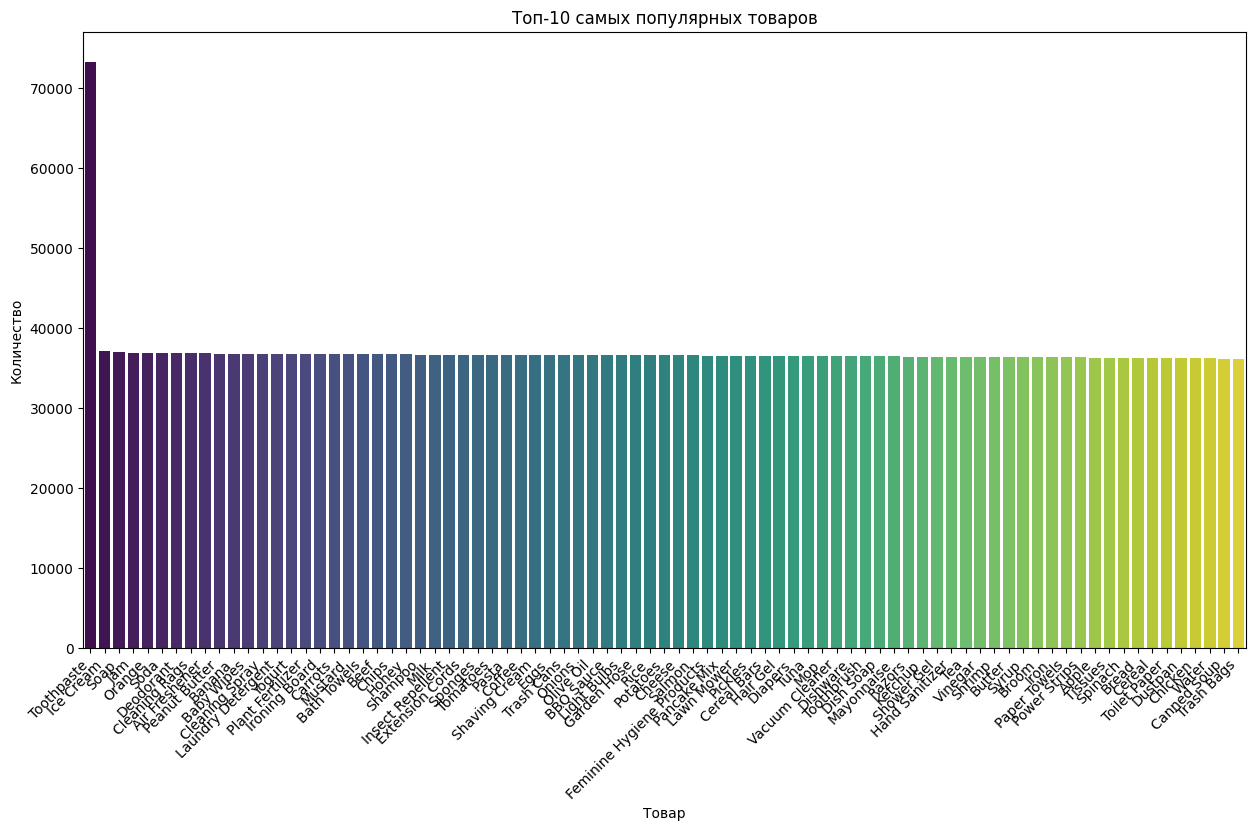

In [21]:
from collections import Counter


all_products = list(chain.from_iterable(df['Product']))

product_counts = Counter(all_products)

top_products = product_counts.most_common(81)
products, counts = zip(*top_products)

plt.figure(figsize=(15, 8))
sns.barplot(x=list(products), y=list(counts), palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Топ-10 самых популярных товаров')
plt.xlabel('Товар')
plt.ylabel('Количество')
plt.show()

In [22]:
df.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"[Ketchup, Shaving Cream, Light Bulbs]",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"[Ice Cream, Milk, Olive Oil, Bread, Potatoes]",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,[Spinach],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"[Tissues, Mustard]",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,[Dish Soap],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


# Dataset prep

In [23]:
transactions = df['Product'].tolist()

In [24]:
te = TransactionEncoder()

In [25]:
te_ary = te.fit(transactions).transform(transactions)

In [26]:
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [27]:
basket_df.head()

,Air Freshener,Apple,BBQ Sauce,Baby Wipes,Banana,Bath Towels,Beef,Bread,Broom,Butter,...,Tomatoes,Toothbrush,Toothpaste,Trash Bags,Trash Cans,Tuna,Vacuum Cleaner,Vinegar,Water,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [28]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 81 columns):
 #   Column                     Non-Null Count    Dtype
---  ------                     --------------    -----
 0   Air Freshener              1000000 non-null  bool 
 1   Apple                      1000000 non-null  bool 
 2   BBQ Sauce                  1000000 non-null  bool 
 3   Baby Wipes                 1000000 non-null  bool 
 4   Banana                     1000000 non-null  bool 
 5   Bath Towels                1000000 non-null  bool 
 6   Beef                       1000000 non-null  bool 
 7   Bread                      1000000 non-null  bool 
 8   Broom                      1000000 non-null  bool 
 9   Butter                     1000000 non-null  bool 
 10  Canned Soup                1000000 non-null  bool 
 11  Carrots                    1000000 non-null  bool 
 12  Cereal                     1000000 non-null  bool 
 13  Cereal Bars                1000000 non-null

# Association Rules

In [29]:
freq_items = apriori(basket_df, min_support=0.01, use_colnames=True, verbose=1)

Processing 6480 combinations | Sampling itemset size 2


In [30]:
freq_items

,support,itemsets
0,0.036266,(Air Freshener)
1,0.035748,(Apple)
2,0.036046,(BBQ Sauce)
3,0.036196,(Baby Wipes)
4,0.036224,(Banana)
...,...,...
76,0.035950,(Tuna)
77,0.035973,(Vacuum Cleaner)
78,0.035817,(Vinegar)
79,0.035665,(Water)
